## 简单demo数据

In [35]:
# 设置绘图
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
#设置字体为SimHei显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
#设置正常显示字符
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
import xgboost
import math

In [36]:
df=pd.read_excel('T_30min.xlsx',index_col=0)


# 使用百分比变化
df['r']=(df['close']/df['open']-1)
df['range']=(df['high']/df['low']-1)
 dataset

,r,range,volume
2017-12-18 09:45:00,0.000914,0.001613,6729
2017-12-18 10:15:00,-0.000483,0.000753,3445
2017-12-18 10:45:00,-0.000806,0.001076,2849
2017-12-18 11:15:00,0.000377,0.000646,1295
2017-12-18 13:15:00,0.000000,0.000376,1269
...,...,...,...
2020-12-17 13:30:00,0.000206,0.000617,4083
2020-12-17 14:00:00,0.000000,0.000360,3955
2020-12-17 14:30:00,-0.000360,0.000669,4976
2020-12-17 15:00:00,-0.000154,0.000411,3783


In [37]:
def create_dataset(dataset:np.ndarray, look_back:int):  # 后一个数据和前look_back个数据有关系
    assert not (isinstance(dataset,np.ndarray) and isinstance(dataset,pd.core.frame.DataFrame)) ,'输入数据格式不符合要求，使用pandas或numpy'
    dataset=np.array(dataset)

    dataX, dataY = [],[]
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)  # .apeend方法追加元素
        dataY.append(dataset[:,0][i + look_back]) #此处Y要第一列（收益率） 
        
    dataX,dataY=np.array(dataX),np.array(dataY)
        
    dataX,dataY=np.reshape(dataX,(dataX.shape[0],-1)),np.reshape(dataY,(-1,1))# 转变为二维数据
    
    # 进行归一化
    from sklearn.preprocessing import MinMaxScaler
    
    scalerX = MinMaxScaler(feature_range=(0, 1))  # 归一化0-1
    scalerX.fit(dataX)
    dataX=scalerX.transform(dataX)

    scalerY = MinMaxScaler(feature_range=(0, 1))  # 归一化0-1
    scalerY.fit(dataY)
    dataY=scalerY.transform(dataY)
    
    return np.array(dataX), np.array(dataY),scalerX,scalerY  # 生成输入数据和输出数据

In [38]:
totX, totY, scalerX, scalerY = create_dataset(np.array(dataset), look_back=20)  # 训练输入输出


def split_dataset(dataset):
    dataset=np.array(dataset)
    train_size = int(len(dataset) * 0.67)  # %67的训练集，剩下测试集
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]  # 训练集和测试集    
    return train,test

trainX,testX=split_dataset(totX)
trainY,testY=split_dataset(totY)
print(trainX.shape)

(4387, 60)


In [39]:
trainX.shape,trainY.shape,testX.shape,testY.shape

((4387, 60), (4387, 1), (2161, 60), (2161, 1))

整理好的数据格式：

1. **trainX:\[length,m,lookback\]**
    * 其中length为数据长度，
    * 每一个时期的数据包括m*lookback个数据，主要在LSTM中用到，其中m为单日数据维度，lookback为选择的期数
    * 在神经网络和xgboost中我们将所有数据变为一维数据
2. **trainY:\[length,k\]**
    * length与trainX的长度相同，k为输出的数据维度（先暂时考虑只输出收益率r？）**因此就算只有一维数据，也需要reshape(n,1)**
3. testX
4. testY

## 神经网络


In [40]:
from keras.models import Sequential  # 采用贯序模型
from keras.layers import Input, Dense, Dropout, Activation,LSTM
from keras.models import Model
from keras.optimizers import SGD
import numpy as np

In [41]:
tBatchSize = 128
'''第一步：选择模型'''
model = Sequential()  # 采用贯序模型

'''第二步：构建网络层'''
'''构建网络只是构建了一个网络结构，并定义网络的参数，此时还没有输入的数据集'''
# 构建的第一个层作为输入层
# Dense 这是第一个隐藏层，并附带定义了输入层，该隐含层有500个神经元。输入则是 784个节点
model.add(Dense(50, input_shape=(60,)))  # 输入层，28*28=784 输入层将二维矩阵换成了一维向量输入
model.add(Activation('relu'))  # 激活函数是relu
model.add(Dropout(0.5))  # 采用50%的dropout  随机取一半进行训练

# 构建的第2个层作为隐藏层2， （如果加上输入层，实际上是第三层）
model.add(Dense(50))  # 隐藏层节点50个
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(50))  # 隐藏层3，节点50个
model.add(Activation('relu'))
# model.add(Dropout(0.5))

# 构建的第3个层作为输出层
model.add(Dense(1))  # 

'''第三步：网络优化和编译'''
#   lr：大于0的浮点数，学习率
#   momentum：大于0的浮点数，动量参数
#   decay：大于0的浮点数，每次更新后的学习率衰减值
#   nesterov：布尔值，确定是否使用Nesterov动量
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  # 优化函数，设定学习率（lr）等参数


model.compile(loss='mean_squared_error', optimizer=sgd)  #均方误差作为损失函数，优化器为Adam

In [42]:
'''
   第四步：训练
'''

'''
   .fit的一些参数
   batch_size：对总的样本数进行分组，每组包含的样本数量
   epochs ：训练次数
   shuffle：是否把数据随机打乱之后再进行训练
   validation_split：拿出百分之多少用来做交叉验证
   verbose：屏显模式 0：不输出  1：输出进度  2：输出每次的训练结果
''';

In [43]:
model.fit(trainX, trainY, batch_size=tBatchSize, epochs=50, shuffle=True, verbose=1, validation_split=0.3)
print('模型训练完成')
# model.evaluate(testX, testY, batch_size=200, verbose=0)


Epoch 1/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0644 - val_loss: 0.0236
Epoch 2/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0182
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0138
Epoch 4/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0110
Epoch 5/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0091
Epoch 6/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0090
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 8/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 9/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 11/50
24/24 [

In [44]:
'''第五步：输出'''
# # 误差评价 ：按batch计算在batch用到的输入数据上模型的误差
scores = model.evaluate(testX, testY, batch_size=tBatchSize, verbose=0)

print("The test loss is %f" % scores)

The test loss is 0.006279


In [45]:

# # 根据模型获取预测结果  为了节约计算内存，也是分组（batch）load到内存中的，
# train_pred= model.predict(trainX, batch_size=tBatchSize, verbose=0)


# train_pred_raw=scalerY.inverse_transform(train_pred)
# testY_raw=scalerY.inverse_transform(testY)

# pd.DataFrame(train_pred_raw[:,0]).plot.hist(title='预测结果')
# pd.DataFrame(testY_raw[:,0]).plot.hist(title='实际结果')



In [46]:
def result_plot(result):
    result_raw=scalerY.inverse_transform(result)
    testY_raw=scalerY.inverse_transform(testY)

    print('预测与实际的收益率情况')
    sns.distplot(pd.DataFrame(result_raw[:,0]))
    sns.distplot(pd.DataFrame(testY_raw[:,0]))
    plt.legend(['预测','实际'])
    plt.show()
    
    result_df=pd.DataFrame({'pred':result_raw[:,0]})
    result_df['real']=testY_raw[:,0]


    result_df['buy']=result_df['pred']>0 #只做多
    result_df['buy_and_sell']=result_df['pred'].apply(lambda x:1 if x>0 else -1 ) # 加做空

    result_df['real_return']=(1+result_df['real']).cumprod()
    result_df['stg_buy']=((result_df['real']*result_df['buy'])+1).cumprod()
    result_df['stg_buy_and_sell']=((result_df['real']*result_df['buy_and_sell'])+1).cumprod()
    return result_df

预测与实际的收益率情况


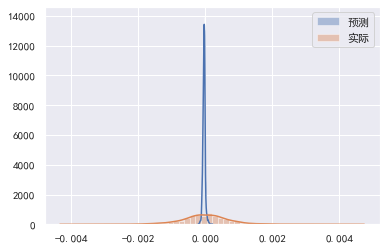

In [47]:

test_pred= model.predict(testX, batch_size=tBatchSize, verbose=0)

result_df=result_plot(test_pred)



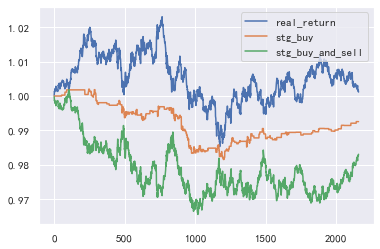

In [48]:
result_df[['real_return','stg_buy','stg_buy_and_sell']].plot()


## LSTM


In [49]:
trainX_LSTM=np.reshape(trainX,(trainX.shape[0],3,-1))
testX_LSTM=np.reshape(testX,(testX.shape[0],3,-1))

trainX.shape

(4387, 60)

In [50]:
model = Sequential()

look_back=20
model.add(LSTM(11, input_shape=(3, look_back)))  # 隐层11个神经元 （可以断调整此参数提高预测精度）
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')  # 评价函数mse，优化器adam
model.fit(trainX_LSTM, trainY, epochs=50, batch_size=100, verbose=1)  # 100次迭代

# save the model
# model.save_weights("my_model_weights.h5") # only save the weight
# model.save('./model_file/{}.h5'.format(MODEL_NAME))

Epoch 1/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 2/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 3/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 4/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 5/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 6/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 7/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 8/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 9/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 10/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 11/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 12/50
44/44 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 13/50
44/44 [==============================

In [51]:
trainPredict = model.predict(trainX_LSTM)
testPredict = model.predict(testX_LSTM)
# 数据反归一化

print('test:',testPredict)
print(trainPredict.shape)
print(trainY.shape)
trainPredict=trainPredict.reshape(trainPredict.shape[0],-1)
trainY=trainY.reshape(trainY.shape[0],1)
testPredict=testPredict.reshape(testPredict.shape[0],-1)
testY=testY.reshape(testY.shape[0],1)


test: [[0.52324075]
 [0.5208097 ]
 [0.5253337 ]
 ...
 [0.5166116 ]
 [0.51469195]
 [0.520622  ]]
(4387, 1)
(4387, 1)


In [52]:
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.5f RMSE' % (testScore))




Train Score: 0.06813 RMSE
Test Score: 0.07949 RMSE


预测与实际的收益率情况


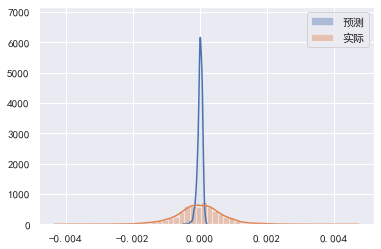

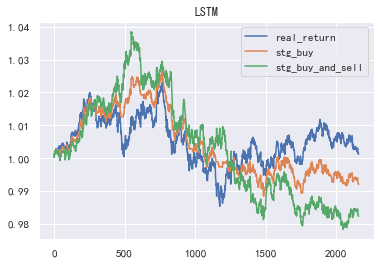

In [53]:

# 根据模型获取预测结果  为了节约计算内存，也是分组（batch）load到内存中的，
result= model.predict(testX_LSTM, batch_size=tBatchSize, verbose=0)

result_df=result_plot(result)
result_df[['real_return','stg_buy','stg_buy_and_sell']].plot(title='LSTM')

## xgboost


In [23]:

import xgboost as xgb

look_back=20
trainX=np.reshape(trainX,(trainX.shape[0],-1))
testX=np.reshape(testX,(testX.shape[0],-1))

#     train_x,train_y,test_x,test_y,scaler=data_processing_xgb(price_series,look_back)
dtrain = xgb.DMatrix(trainX, label = trainY)
dtest = xgb.DMatrix(testX)
# 参数设置
params={
    'booster':'gbtree',
    'objective':'reg:squarederror',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':10,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.025,
    'seed':0,#随机数的种子
    # 'nthread':8, #XGBoost运行时的线程数。缺省值是当前系统可以获得的最大线程数
    }

watchlist = [(dtrain,'train')]
# 进行训练
model=xgb.train(params,dtrain,num_boost_round=1000,evals=watchlist,verbose_eval=1000)



[0]	train-auc:0.50889
[999]	train-auc:0.56633


In [24]:
# 预测
test_predict=model.predict(dtest)
test_predict=np.reshape(test_predict,(-1,1))
test_predict

array([[0.5315775 ],
       [0.51626873],
       [0.54727185],
       ...,
       [0.50407475],
       [0.47649124],
       [0.5220839 ]], dtype=float32)

预测与实际的收益率情况


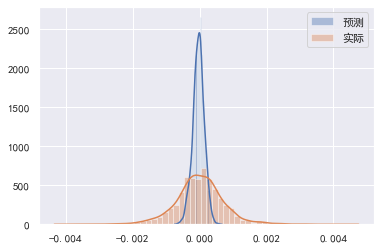

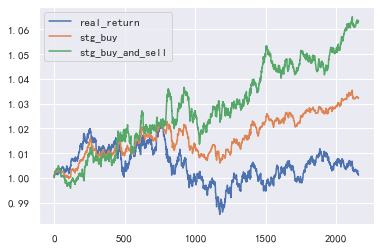

In [25]:
result_df=result_plot(test_predict)
result_df[['real_return','stg_buy','stg_buy_and_sell']].plot()

## 隐马尔科夫链
由于只用到前一期的数据，因此输入的数据结构需要有所不同


In [26]:

from hmmlearn import hmm
import numpy as np
from matplotlib import pyplot as plt

In [27]:
def pre_process(data):
    """
    这个函数进行数据预处理，返回训练所需数据
    """
    volume = data['volume']
    close = data['close']
    
    bday=6 # 所需获取的提前的数据天数
    
    logDel = np.log(np.array(data['high'])) - np.log(np.array(data['low'])) #时段内振幅收益
    logRet_1 = np.array(np.diff(np.log(close))) #  log(Pt/Pt-1)
    logRet_5 = np.log(np.array(close[bday:])) - np.log(np.array(close[:-bday])) # 五日（时期）收益率
    logVol_5 = np.log(np.array(volume[bday:])) - np.log(np.array(volume[:-bday])) #五日（时期）交易量变化
    Date = pd.to_datetime(data.index[bday:])
    
    # 保持所有的数据长度相同
    logDel = logDel[bday:]
    logRet_1 = logRet_1[bday-1:]
    close = close[bday:]
    
    info_df=pd.DataFrame({'Date': Date, 'close':close,'logReg_1': logRet_1}).set_index('Date') # 数据的基础信息
    A = np.column_stack([logDel, logRet_5])#,logVol_5,logRet_1])# 训练所用指标

    return info_df,A

In [28]:
def result_plot(result_df,only=False):
    """
    画图
    """
    
    hidden_states=result_df.states
    long = result_df.long  # 多头（买入）
    short = result_df.short  # 空头（卖出）
    
    if only !=True:
        plt.figure(figsize=(10, 10))

        """
        各时段所对应隐含状态
        """
        plt.subplot(221)
        for i in range(n):
            pos = (hidden_states == i)
            plt.plot(result_df.close[pos], 'o', label='hidden state %d' % i, lw=2)
            plt.legend()
        plt.title('各时段隐含状态')
        #     plt.show()

        """
        各隐含状态对应收益率图形
        """
        plt.subplot(222)
        for i in range(n):
            pos = (hidden_states == i)
            pos = np.append(1, pos[:-1]) # 后移一个时期
            result_df['state_ret%d' % i] = result_df.logReg_1.multiply(pos)
            data_i = np.exp(result_df['state_ret%d' % i].cumsum())
            plt.plot_date(result_df.index, data_i, '-', label='hidden state %d' % i)
            plt.legend()
        plt.title('各隐含状态对应收益率')
        #     plt.show()

        """
        各隐含状态占比图形
        """
        plt.subplot(223)
        countDict = dict()
        proportitionDict = dict()
        for i in range(n):
            countDict[i] = list(hidden_states).count(i) # 各个状态的数量
            proportitionDict[i] =list(hidden_states).count(i)/len(hidden_states)# 各个状态占比

        plt.pie(list(proportitionDict.values()),labels=list(proportitionDict))
        plt.legend()
        plt.title('各个隐含状态占比')
        #     plt.show()
    
        """
        策略收益率
        """
        plt.subplot(224)
    
    else:
        plt.figure(figsize=(10,6))

    # plt.figure(figsize=(10, 7))
#     plt.plot(result_df['stg_r'], 'r-',label='策略收益率') # 策略收益函数
    plt.plot(result_df['index_r'],'y',label='指数做多',linewidth=0.5) # 原收益函数
    plt.plot(result_df['adj_r'],'r',label='策略收益率') # 原收益函数
    
    plt.plot(result_df['index_r_short'],'g',label='指数做空',linewidth=0.5) # 原收益函数


    plt.title('策略收益率与指数收益率')
    plt.legend()
    plt.show()
    
    # return operate_df,long,short

In [29]:
def train_model(data):
    """
    传入DataFrame，用来训练模型
    """
    info_df,A=pre_process(data)
    model = hmm.GaussianHMM(n_components=n, covariance_type="full", n_iter=200000).fit(A) #拟合GaussianHMM
    return model

In [30]:
def model_order(model,data):
    """
    传入模型和DataFrame，
    获得各个隐含状态的收益率排名
    """
    info_df,A=pre_process(data)
    hidden_states = model.predict(A)  # 模型的预测
    info_df.insert(2, 'state',hidden_states)
    series = info_df.logReg_1
    templist = [] # 各个策略的最终收益率

    for i in range(n):
        pos = (hidden_states == i)
        pos = np.append(1, pos[:-1]) # 后移一个时期
        info_df['state_ret%d' % i] = series.multiply(pos)
        data_i = np.exp(info_df['state_ret%d' % i].cumsum())
        templist.append(data_i[-1])# 得到期末的某一种隐含状态对应的收益率
    templist = np.array(templist).argsort()
    return templist


def get_result(model,templist,data):    
    global fee,margin

    """
    传入模型和DataFrame，用模型预测隐含状态，并输出回测结果
    """
    info_df,A=pre_process(data)
    hidden_states = model.predict(A)  # 模型的预测
    """
    计算各项数据，并到df中
    """
    df=info_df
    
    if margin !=1:
        df['logReg_1']/=margin
    
    df['states']=hidden_states
    long = (hidden_states == templist[-1]) # 收益好的隐含状态对应买入
    short = (hidden_states == templist[0])  # 空头（卖出）
    long = np.append(0, long[:-1])
    short = np.append(0, short[:-1])
    df['long']=long
    df['short']=short
    df['stg_r_1']= info_df.logReg_1.multiply(long) - info_df.logReg_1.multiply(short) # 做多做空
    df['stg_r']=np.exp((df['stg_r_1']*1).cumsum())    
    df['index_r']=np.exp(df['logReg_1'].cumsum())
    
    df['index_r_short']=np.exp(-df['logReg_1'].cumsum())

    df['trade']=(df['long']!=df['long'].shift(1)) | (df['short']!=df['short'].shift(1))
    
    df['adj_r']=np.exp((df['stg_r_1']-(df['trade']+0)*fee).cumsum())

    
    print('策略收益率:{:.2f}%,基准收益率：{:.2f}%，超额收益率：{:.2f}%'.format((df['stg_r'][-1]-1)*100,(df['index_r'][-1]-1)*100,(df['stg_r'][-1]-df['index_r'][-1])*100))
    trade_num=(df['trade']+0).sum()
    print('调仓次数：{}，预估交易手续费：{:.2f}%'.format(trade_num,trade_num*fee))
    print('总时段数：{}，做空时段：{}'.format(len(df),df.short.sum()))

    return df


In [31]:
margin=1 # 保证金比率，不考虑杠杆，则使用此
fee=3/1000000 # (100万合约-->3元)

In [32]:
n=2

[[0.49998397 0.50001603]
 [0.49996514 0.50003486]]
策略收益率:2.06%,基准收益率：4.66%，超额收益率：-2.59%
调仓次数：1090，预估交易手续费：0.00%
总时段数：6563，做空时段：1950


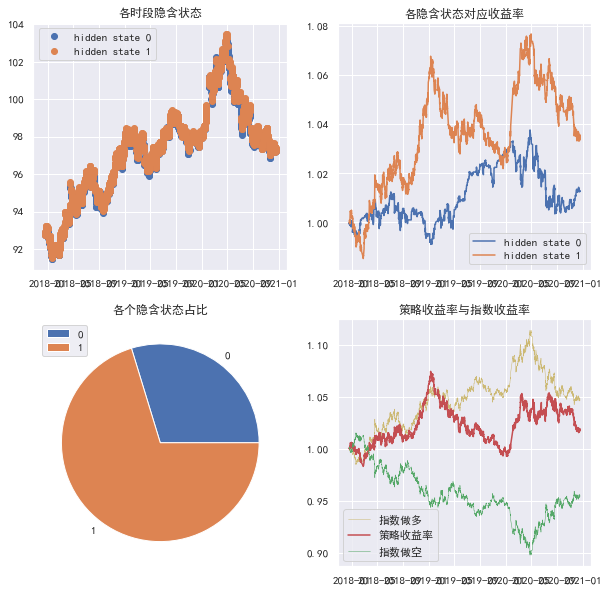

In [33]:
model=train_model(df) # 使用训练集训练模型
print(model.transmat_) # 转移概率矩阵
templist=model_order(model,df) # 使用模型得到隐含状态排名
operate_df=get_result(model,templist,df) # 高收益隐含状态买入，
result_plot(operate_df);

## 计算评价指标


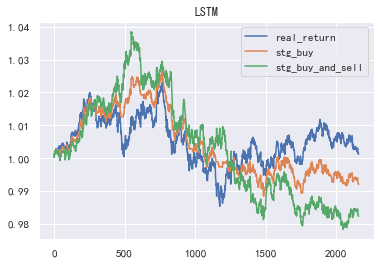

,pred,real,buy,buy_and_sell,real_return,stg_buy,stg_buy_and_sell,buy_rr,buy_sell_rr
0,0.000087,0.000205,True,1,1.000205,1.000205,1.000205,0.000205,0.000205
1,0.000064,0.000818,True,1,1.001023,1.001023,1.001023,0.000818,0.000818
2,0.000106,0.000307,True,1,1.001329,1.001329,1.001329,0.000307,0.000307
3,0.000084,-0.000153,True,1,1.001176,1.001176,1.001176,-0.000153,-0.000153
4,0.000093,0.000460,True,1,1.001636,1.001636,1.001636,0.000460,0.000460
...,...,...,...,...,...,...,...,...,...
2156,0.000108,-0.000257,True,1,1.001456,0.992399,0.982932,-0.000257,-0.000257
2157,-0.000008,0.000206,False,-1,1.001662,0.992399,0.982730,0.000000,-0.000206
2158,0.000026,0.000000,True,1,1.001662,0.992399,0.982730,0.000000,0.000000
2159,0.000008,-0.000360,True,1,1.001302,0.992042,0.982376,-0.000360,-0.000360


In [91]:
result_df['buy_rr']=result_df['real']*result_df['buy']
result_df['buy_sell_rr']=result_df['real']*result_df['buy_and_sell']
result_df[['real_return','stg_buy','stg_buy_and_sell']].plot(title='LSTM')
plt.show()
result_df

In [69]:
from source.Ratio import ratio

In [84]:
pd.set_option('display.float_format',lambda x : '%.6f' % x)

In [88]:
ratio().cal_ratio(pd.DataFrame(result_df[['real','buy_rr','buy_sell_rr']]))

,real,buy_rr,buy_sell_rr
信息比率,0.017360,-0.105659,-0.175676
累计收益率,1.001147,0.991889,0.982225
年化收益率,0.000200,-0.000912,-0.002025
每日收益率,0.000001,-0.000004,-0.000008
年化波动率,0.011528,0.008636,0.011527
最大每日收益,0.004343,0.004343,0.004343
最大每日损失,-0.003930,-0.002867,-0.003179
上涨天数,1039.000000,635.000000,1026.000000
下跌天数,1048.000000,657.000000,1061.000000
胜率,0.497844,0.491486,0.491615
